Train an MLP to predict frame-wise penetration mean/std from operating
conditions + time.

Data source: outputs created by mie_postprocessing.prepare_penetration_data

Each frame across all conditions is a supervised sample with:
  Features (X):
    [chamber_pressure, injection_pressure, injection_duration_us,
     control_backpressure, time_s]
  Targets (Y):
    [mean, std]   # both already geometry-corrected in preparation step

Improvements over the initial version:
  - Per-output metrics (mean vs std) reported separately.
  - Std positivity enforced by clamping std >= 0 after inverse transform.
  - Grouped split by condition (T-group × condition index) to evaluate
    performance on unseen conditions, not just unseen frames.
  - Residual analysis by time: plots mean absolute error vs. frame time.

Normalization, training loop and tricks are aligned with the old
train_mlp_spray.py for consistency (standardization, AMP, schedulers,
early stopping, etc.).

In [1]:
from __future__ import annotations

import os
import re
import json
import math
import random
from pathlib import Path
from typing import List, Tuple, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from standarizer import Standardizer

In [2]:
# =====================
# Experimental mapping
# Choose the test matrix made and saved in test_matrix/
# =====================

from test_matrix.Nozzle2 import T_GROUP_TO_COND

In [3]:
# =====================
# Config
# =====================
CONFIG = {
    # Data roots
    "cine_root": r"C:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\BC20241017_HZ_Nozzle2",
    "results_root": r"C:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\BC20241017_HZ_Nozzle2\penetration_results",
    "repetitions_per_condition": 5,

    # Training / data handling
    "seed": 42,
    "use_cuda_if_available": True,
    "train_val_test_split": [0.7, 0.15, 0.15],
    # When True, split by condition (T-group × condition index) rather than frames.
    # This better reflects generalization to unseen operating conditions.
    "grouped_split": True,
    "batch_size": 256,
    "num_workers": 0,

    # Model
    "hidden_sizes": [64, 64, 32],
    "activation": "tanh",        # relu | gelu | prelu | tanh
    "dropout": 0.3,
    "normalization": "layer",    # none | batch | layer
    "weight_norm": False,
    # Output head activation: we keep overall output activation as 'none' and
    # enforce std positivity post inverse-transform (more robust with standardized targets).
    "output_activation": "none", # none | relu | softplus (unused for std; we clamp instead)

    # Optimization
    "epochs": 500,
    "optimizer": "adamw",
    "lr": 5e-3,
    "weight_decay": 1e-4,
    "l1_lambda": 0.0,
    "gradient_clip_norm": 1.0,

    # Regularization tricks

    "mixup_alpha": 0.1,           # 0 disables

    # Scheduler
    "scheduler": "plateau",      # none | plateau | cosine
    "plateau_patience": 10,
    "plateau_factor": 0.5,
    "cosine_T_max": 100,

    # Early stopping
    "early_stop_patience": 80,
    "min_delta": 1e-5,

    # Automatic Mixed Precision (AMP)
    "use_amp": True,

    # Output 
    "out_dir": None,

    # Target/feature standardization toggles (align to the original script behavior)
    "standardize_features": True,
    "standardize_targets": True,

    # Std enforcement: minimum value after inverse-transform (in raw units)
    "std_clamp_min": 0.0,

    # Residual plots
    "plot_residuals": True,
    "residual_bins": 100,


    "input_noise_std": 0.01,  # stddev of Gaussian noise added to inputs during training; 0 disables, 

    # Names and physical metadata used for downstream inference
    "feature_names": [
        "chamber_pressure",
        "injection_pressure",
        "injection_duration",   # microseconds
        "control_backpressure",
        "time_s"                 # seconds
    ],
    "target_names": ["mean", "std"],
    "frame_rate_hz": 34_000.0,
    "correction_factor": float(1.0 / np.cos(np.deg2rad(20.0))),
}

In [4]:
# Outputs
CONFIG["out_dir"]= Path("runs_mlp/" + str(Path(CONFIG["cine_root"]).name))

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


device = torch.device(
    "cuda" if (torch.cuda.is_available() and CONFIG["use_cuda_if_available"]) else "cpu"
)

In [5]:
# =====================
# Utils / preprocessing
# =====================
def numeric_then_alpha_key(p: Path):
    m = re.search(r"\d+", p.stem)
    if m:
        return (0, int(m.group(0)))
    return (1, p.name.lower())


def infer_t_group_from_path(path: Path) -> Optional[int]:
    m = re.search(r"[\\/]T(\d+)[\\/]", str(path))
    if m:
        return int(m.group(1))
    return None


def parse_condition_idx(name: str) -> Optional[int]:
    m = re.search(r"condition_(\d+)", name)
    return int(m.group(1)) if m else None


def build_injection_duration_map(cine_root: Path, t_group: int, reps_per_cond: int) -> Dict[int, float]:
    """
    Build a mapping: condition_index (1-based) -> injection_duration_us

    Uses the same grouping logic as in penetration_files_to_data.py: sort the files
    in Cine/T*/penetration numerically and group by reps_per_cond; the first file
    of each group carries the cine number.
    """
    pen_dir = cine_root / f"T{t_group}" / "penetration"
    if not pen_dir.exists():
        return {}
    files = sorted([p for p in pen_dir.iterdir() if p.is_file()], key=numeric_then_alpha_key)
    if not files:
        return {}
    cond_map: Dict[int, float] = {}
    total_conditions = len(files) // reps_per_cond
    for cond_idx in range(1, total_conditions + 1):
        first_file = files[(cond_idx - 1) * reps_per_cond]
        m = re.search(r"(\d+)", first_file.stem)
        if not m:
            continue
        cine_number = int(m.group(1))
        inj_dur = cine_to_injection_duration_us(cine_number)
        cond_map[cond_idx] = float(inj_dur)
    return cond_map

In [ ]:
def load_frame_stats_to_arrays(
    cine_root: Path,
    results_root: Path,
    reps_per_cond: int,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Scan `results_root` for per-condition frame statistics (.npz) and assemble them into
    feature and target arrays for downstream ML modeling.

    Returns:
        X (ndarray): Shape (N, 5). Features per frame:
            [chamber_pressure, injection_pressure, injection_duration_us, control_backpressure, time_s]
        Y (ndarray): Shape (N, 2). Targets per frame:
            [mean, std]
        groups (ndarray): Shape (N,). Integer group IDs (e.g., for GroupKFold) based on condition.
        times (ndarray): Shape (N,). Time values per frame (for residual analysis).
        groups_str (ndarray): Shape (N,). Original condition keys (e.g., 'T1_cond01') for traceability.

    Notes:
        - All rows with NaNs in features or targets are removed.
        - Injection duration is read from condition metadata if available; otherwise, it is inferred.
        - Default fallback values: injection_pressure=2000.0 bar, control_backpressure=4.0 bar.
    """

    # Initialize containers for all data to be concatenated at the end
    X_list: List[np.ndarray] = []          # Feature arrays from all conditions
    Y_list: List[np.ndarray] = []          # Target arrays from all conditions
    groups_str_list: List[str] = []        # String labels for each sample, for grouped splitting
    times_list: List[np.ndarray] = []      # Time vectors for each sample

    # Find all experiment subdirectories named like "T1", "T2", ...
    t_dirs = sorted(
        [p for p in results_root.iterdir() if p.is_dir() and p.name.startswith("T")],
        key=lambda p: int(p.name[1:]) if p.name[1:].isdigit() else 9999
    )

    # Iterate over each test group directory (T1, T2, ...)
    for t_dir in t_dirs:
        t_group = int(t_dir.name[1:])
        cond = T_GROUP_TO_COND.get(t_group)  # Retrieve metadata for this test group
        if cond is None:
            continue

        # Find all per-condition .npz stats files and sort them by condition index
        files = sorted(
            t_dir.glob("condition_*_frame_stats.npz"),
            key=lambda p: parse_condition_idx(p.name) or 0
        )

        # Loop over each condition result file
        for f in files:
            cidx = parse_condition_idx(f.name)
            if cidx is None:
                continue

            # Load per-frame time, mean, std arrays from the .npz file
            try:
                z = np.load(str(f), allow_pickle=True)
                time_s = z["time_s"].astype(float)
                mean = z["mean"].astype(float)
                std = z["std"].astype(float)
            except Exception:
                # Skip corrupted or incomplete files
                continue

            # Attempt to read injection duration from metadata; fall back to inference if absent
            try:
                inj_dur = float(cond["injection_duration"])
            except Exception:
                inj_map = build_injection_duration_map(cine_root, t_group, reps_per_cond)
                inj_dur = inj_map.get(cidx, np.nan)

            # Build a boolean mask to drop frames with missing data
            valid = ~(np.isnan(mean) | np.isnan(std) | np.isnan(time_s))
            if not np.any(valid):
                continue

            # Extract or default key condition parameters for feature matrix
            cp = float(cond["chamber_pressure"])
            try:
                ip = float(cond["injection_pressure"])
            except Exception:
                ip = 2000.0  # Default if not provided
            try:
                cb = float(cond["control_backpressure"])
            except Exception:
                cb = 4.0     # Default if not provided
            inj = float(inj_dur)

            # Assemble feature matrix: one row per valid frame
            feats = np.stack([
                np.full_like(time_s, cp),
                np.full_like(time_s, ip),
                np.full_like(time_s, inj),
                np.full_like(time_s, cb),
                time_s,
            ], axis=1)

            f_valid = feats[valid]
            y_valid = np.stack([mean, std], axis=1)[valid]

            # Append features and targets from this condition
            X_list.append(f_valid)
            Y_list.append(y_valid)

            # Record condition key for group-splitting and traceability
            key = f"T{t_group}_cond{cidx:02d}"
            groups_str_list.extend([key] * f_valid.shape[0])
            times_list.append(time_s[valid])

    # Sanity check: no usable data found
    if not X_list:
        raise RuntimeError(f"No usable frame stats found under {results_root}")

    # Concatenate per-condition arrays into global datasets
    X = np.concatenate(X_list, axis=0)
    Y = np.concatenate(Y_list, axis=0)

    # Drop any rows with NaNs in features (e.g., missing injection duration)
    mask = ~np.isnan(X).any(axis=1)
    X, Y = X[mask], Y[mask]

    # Apply the same mask to times and group labels
    times = np.concatenate(times_list, axis=0)[mask]
    groups_str = np.array(groups_str_list, dtype=object)[mask]

    # Encode string condition keys (e.g., 'T1_cond01') into integer group IDs
    unique_keys = {k: i for i, k in enumerate(sorted(set(groups_str.tolist())))}
    groups = np.array([unique_keys[k] for k in groups_str.tolist()], dtype=int)

    return X, Y, groups, times, groups_str


In [7]:
def make_split(n: int, ratios: List[float], seed: int) -> Tuple[List[int], List[int], List[int]]:
    assert abs(sum(ratios) - 1.0) < 1e-6
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    n_train = int(n * ratios[0])
    n_val = int(n * ratios[1])
    train_idx = idx[:n_train].tolist()
    val_idx = idx[n_train:n_train + n_val].tolist()
    test_idx = idx[n_train + n_val:].tolist()
    return train_idx, val_idx, test_idx

def make_grouped_split(groups: np.ndarray, ratios: List[float], seed: int) -> Tuple[List[int], List[int], List[int]]:
    """Split indices by disjoint group labels (e.g., condition ids).

    - groups: int array of shape (N,), group id for each sample.
    - ratios: [train, val, test]
    - Returns: lists of sample indices for each split.
    """
    assert abs(sum(ratios) - 1.0) < 1e-6
    rng = np.random.default_rng(seed)
    uniq = np.unique(groups)
    rng.shuffle(uniq)
    n = len(uniq)
    n_train = int(n * ratios[0])
    n_val = int(n * ratios[1])
    g_tr = set(uniq[:n_train].tolist())
    g_v = set(uniq[n_train:n_train + n_val].tolist())
    g_te = set(uniq[n_train + n_val:].tolist())
    idx = np.arange(groups.size)
    tr_idx = idx[np.isin(groups, list(g_tr))].tolist()
    v_idx = idx[np.isin(groups, list(g_v))].tolist()
    te_idx = idx[np.isin(groups, list(g_te))].tolist()
    return tr_idx, v_idx, te_idx

In [8]:
class FrameDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, input_noise_std: float = 0.0):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        self.input_noise_std = float(input_noise_std)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx: int):
        x = self.X[idx]
        y = self.Y[idx]
        if self.input_noise_std > 0:
            x = x + torch.randn_like(x) * self.input_noise_std
        return x, y

In [9]:
def activation_factory(name: str):
    name = (name or "relu").lower()
    if name == "relu":
        return nn.ReLU()
    if name == "gelu":
        return nn.GELU()
    if name == "prelu":
        return nn.PReLU()
    if name == "tanh":
        return nn.Tanh()
    return nn.ReLU()


def norm_factory(name: str, dim: int):
    name = (name or "none").lower()
    if name == "batch":
        return nn.BatchNorm1d(dim)
    if name == "layer":
        return nn.LayerNorm(dim)
    return None


def maybe_weight_norm(layer: nn.Module, enabled: bool):
    return nn.utils.weight_norm(layer) if enabled else layer


In [10]:
class MLP(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, hidden: List[int], activation: str,
                 dropout: float = 0.0, normalization: str = "none", weight_norm: bool = False,
                 output_activation: str = "none"):
        super().__init__()
        dims = [in_dim] + hidden + [out_dim]
        act = activation_factory(activation)
        layers: List[nn.Module] = []
        for i in range(len(dims) - 2):
            d_in, d_out = dims[i], dims[i + 1]
            lin = maybe_weight_norm(nn.Linear(d_in, d_out), weight_norm)
            layers.append(lin)
            norm = norm_factory(normalization, d_out)
            if norm is not None:
                layers.append(norm)
            layers.append(act)
            if dropout and dropout > 0:
                layers.append(nn.Dropout(p=dropout))
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.net = nn.Sequential(*layers)
        self.output_activation = output_activation

    def forward(self, x):
        x = self.net(x)
        if self.output_activation == "relu":
            x = torch.relu(x)
        elif self.output_activation == "softplus":
            x = torch.nn.functional.softplus(x)
        return x

In [11]:
def mixup_regression(x, y, alpha: float = 0.0):
    if not alpha or alpha <= 0.0:
        return x, y
    lam = np.random.beta(alpha, alpha)
    perm = torch.randperm(x.size(0), device=x.device)
    x = lam * x + (1 - lam) * x[perm]
    y = lam * y + (1 - lam) * y[perm]
    return x, y


In [12]:
def train_model(X: np.ndarray, Y: np.ndarray, cfg: dict):
    """Train the model and return loaders plus training history and scalers.

    Note: Splitting logic is handled by caller to support grouped splits.
    """
    # Expect caller to pass explicit split indices in cfg if grouped split is used
    if all(k in cfg for k in ("train_idx", "val_idx", "test_idx")):
        train_idx, val_idx, test_idx = cfg["train_idx"], cfg["val_idx"], cfg["test_idx"]
    else:
        n = X.shape[0]
        train_idx, val_idx, test_idx = make_split(n, cfg["train_val_test_split"], cfg["seed"])
    # Standardization
    x_scaler = Standardizer().fit(X[train_idx]) if cfg.get("standardize_features", True) else None
    y_scaler = Standardizer().fit(Y[train_idx]) if cfg.get("standardize_targets", True) else None
    Xtr = x_scaler.transform(X[train_idx]) if x_scaler else X[train_idx]
    Ytr = y_scaler.transform(Y[train_idx]) if y_scaler else Y[train_idx]
    Xv = x_scaler.transform(X[val_idx]) if x_scaler else X[val_idx]
    Yv = y_scaler.transform(Y[val_idx]) if y_scaler else Y[val_idx]
    Xte = x_scaler.transform(X[test_idx]) if x_scaler else X[test_idx]
    Yte = y_scaler.transform(Y[test_idx]) if y_scaler else Y[test_idx]

    # Dataloaders
    dl_tr = DataLoader(FrameDataset(Xtr, Ytr, input_noise_std=cfg["input_noise_std"]),
                       batch_size=cfg["batch_size"], shuffle=True, num_workers=cfg["num_workers"])
    dl_v = DataLoader(FrameDataset(Xv, Yv, input_noise_std=0.0),
                      batch_size=cfg["batch_size"], shuffle=False, num_workers=cfg["num_workers"])
    dl_te = DataLoader(FrameDataset(Xte, Yte, input_noise_std=0.0),
                       batch_size=cfg["batch_size"], shuffle=False, num_workers=cfg["num_workers"])

    # Model
    in_dim = X.shape[1]
    out_dim = Y.shape[1]
    model = MLP(in_dim, out_dim, cfg["hidden_sizes"], cfg["activation"],
                dropout=cfg["dropout"], normalization=cfg["normalization"],
                weight_norm=cfg["weight_norm"], output_activation=cfg["output_activation"]).to(device)

    # Optimizer
    if cfg["optimizer"].lower() == "adamw":
        opt = AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    else:
        opt = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

    # Scheduler
    scheduler = None
    if cfg["scheduler"] == "plateau":
        scheduler = ReduceLROnPlateau(opt, mode="min", factor=cfg["plateau_factor"], patience=cfg["plateau_patience"])
    elif cfg["scheduler"] == "cosine":
        scheduler = CosineAnnealingLR(opt, T_max=cfg["cosine_T_max"])

    scaler = torch.cuda.amp.GradScaler(enabled=cfg["use_amp"] and (device.type == "cuda"))
    criterion = nn.MSELoss()
    history = {"train_loss": [], "val_loss": [], "lr": []}
    best_val = float("inf"); best_epoch = -1

    for epoch in range(cfg["epochs"]):
        model.train()
        train_loss = 0.0
        for xb, yb in dl_tr:
            xb = xb.to(device); yb = yb.to(device)
            xb, yb = mixup_regression(xb, yb, cfg["mixup_alpha"])
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=cfg["use_amp"] and (device.type == "cuda")):
                preds = model(xb)
                loss = criterion(preds, yb)
                if cfg["l1_lambda"] and cfg["l1_lambda"] > 0.0:
                    l1 = sum(p.abs().sum() for p in model.parameters())
                    loss = loss + cfg["l1_lambda"] * l1
            scaler.scale(loss).backward()
            if cfg["gradient_clip_norm"] is not None:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg["gradient_clip_norm"])
            scaler.step(opt); scaler.update()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(dl_tr.dataset)

        model.eval(); val_loss = 0.0
        with torch.no_grad():
            for xb, yb in dl_v:
                xb = xb.to(device); yb = yb.to(device)
                preds = model(xb)
                val_loss += criterion(preds, yb).item() * xb.size(0)
        val_loss /= max(1, len(dl_v.dataset))

        if scheduler is not None:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(val_loss); current_lr = opt.param_groups[0]["lr"]
            else:
                scheduler.step(); current_lr = opt.param_groups[0]["lr"]
        else:
            current_lr = opt.param_groups[0]["lr"]

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["lr"].append(current_lr)

        improved = (best_val - val_loss) > cfg["min_delta"]
        if improved:
            best_val = val_loss; best_epoch = epoch
            os.makedirs(cfg["out_dir"], exist_ok=True)
            torch.save(model.state_dict(), os.path.join(cfg["out_dir"], "best_model.pt"))
        if (epoch - best_epoch) >= cfg["early_stop_patience"]:
            print(f"Early stopping at epoch {epoch}. Best val @ {best_epoch}: {best_val:.6f}")
            break
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:03d}: train {train_loss:.6f} | val {val_loss:.6f} | lr {current_lr:.2e}")

    # Load best
    model.load_state_dict(torch.load(os.path.join(cfg["out_dir"], "best_model.pt"), map_location=device))
    scalers = {"x": x_scaler.state_dict() if x_scaler else None,
               "y": y_scaler.state_dict() if y_scaler else None}
    return model, dl_tr, dl_v, dl_te, history, scalers

In [13]:
def _inverse_transform_y(arr: np.ndarray, y_scaler_state, cfg: dict) -> np.ndarray:
    """Inverse-transform Y using scaler state if present, then clamp std >= min.

    - arr: (N,2) predictions or targets in standardized space.
    - returns: (N,2) in raw units with std clamped.
    """
    out = arr.copy()
    if y_scaler_state is not None:
        mu = np.array(y_scaler_state["mu"])
        sigma = np.array(y_scaler_state["sigma"])
        out = out * sigma + mu
    # Clamp std (second column) to be >= specified minimum
    out[:, 1] = np.maximum(cfg.get("std_clamp_min", 0.0), out[:, 1])
    return out


def _metrics_pairwise(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """Compute aggregate metrics over both outputs jointly."""
    return {
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "R2": float(r2_score(y_true, y_pred)),
    }


def _metrics_per_output(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, Dict[str, float]]:
    """Compute metrics for each output separately and return a dict keyed by name."""
    names = ["mean", "std"]
    out: Dict[str, Dict[str, float]] = {}
    for i, name in enumerate(names):
        yt = y_true[:, i]
        yp = y_pred[:, i]
        out[name] = {
            "MAE": float(mean_absolute_error(yt, yp)),
            "RMSE": float(np.sqrt(mean_squared_error(yt, yp))),
            "R2": float(r2_score(yt, yp)),
        }
    return out

In [14]:
def evaluate(model: nn.Module, dataloader: DataLoader, y_scaler_state, cfg: dict):
    """Run inference on a dataloader and compute overall and per-output metrics in raw units."""
    model.eval()
    preds_list, targets_list = [], []
    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device); yb = yb.to(device)
            pred = model(xb)
            preds_list.append(pred.cpu().numpy())
            targets_list.append(yb.cpu().numpy())
    preds_std = np.concatenate(preds_list, axis=0)
    targets_std = np.concatenate(targets_list, axis=0)
    preds = _inverse_transform_y(preds_std, y_scaler_state, cfg)
    targets = _inverse_transform_y(targets_std, y_scaler_state, cfg)
    metrics_overall = _metrics_pairwise(targets, preds)
    metrics_per_output = _metrics_per_output(targets, preds)
    return preds, targets, {"overall": metrics_overall, "per_output": metrics_per_output}


In [15]:
def plot_error_vs_time(out_dir: str, times: np.ndarray, y_true: np.ndarray, y_pred: np.ndarray, split_name: str, cfg: dict):
    """Plot mean absolute error vs frame time for each output and save figures.

    - times: (N,) seconds
    - y_true, y_pred: (N,2) arrays in raw units
    """
    import matplotlib.pyplot as plt
    # Compute absolute errors
    abs_err = np.abs(y_pred - y_true)  # (N,2)
    # Bin by time
    nbins = int(cfg.get("residual_bins", 100))
    tmin, tmax = float(times.min()), float(times.max())
    if tmax <= tmin:
        return
    edges = np.linspace(tmin, tmax, nbins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    # Aggregate mean abs error per bin
    mae_mean = np.zeros(nbins)
    mae_std = np.zeros(nbins)
    for i in range(nbins):
        m = (times >= edges[i]) & (times < edges[i + 1])
        if not np.any(m):
            mae_mean[i] = np.nan
            mae_std[i] = np.nan
        else:
            mae_mean[i] = np.nanmean(abs_err[m, 0])
            mae_std[i] = np.nanmean(abs_err[m, 1])
    # Plot
    plt.figure(figsize=(7, 4))
    plt.plot(centers, mae_mean, label="MAE mean", lw=1.8)
    plt.plot(centers, mae_std, label="MAE std", lw=1.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Mean Absolute Error (raw units)")
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    os.makedirs(out_dir, exist_ok=True)
    plt.savefig(os.path.join(out_dir, f"residuals_vs_time_{split_name}.png"), dpi=150)
    plt.close()

Loaded dataset: X=(2418, 5), Y=(2418, 2)
Epoch 001: train 0.673295 | val 0.300035 | lr 5.00e-03


C:\Users\Jiang\AppData\Local\Temp\ipykernel_8464\732658223.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=cfg["use_amp"] and (device.type == "cuda"))
C:\Users\Jiang\AppData\Local\Temp\ipykernel_8464\732658223.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg["use_amp"] and (device.type == "cuda")):


Epoch 005: train 0.439728 | val 0.249831 | lr 5.00e-03
Epoch 010: train 0.366979 | val 0.244719 | lr 5.00e-03
Epoch 015: train 0.376101 | val 0.236560 | lr 5.00e-03
Epoch 020: train 0.285372 | val 0.228814 | lr 5.00e-03
Epoch 025: train 0.345629 | val 0.206844 | lr 5.00e-03
Epoch 030: train 0.339455 | val 0.199557 | lr 5.00e-03
Epoch 035: train 0.339378 | val 0.183654 | lr 5.00e-03
Epoch 040: train 0.354200 | val 0.176985 | lr 5.00e-03
Epoch 045: train 0.343960 | val 0.166115 | lr 5.00e-03
Epoch 050: train 0.348051 | val 0.154302 | lr 5.00e-03
Epoch 055: train 0.326435 | val 0.163158 | lr 5.00e-03
Epoch 060: train 0.308031 | val 0.153611 | lr 5.00e-03
Epoch 065: train 0.313073 | val 0.143264 | lr 5.00e-03
Epoch 070: train 0.316691 | val 0.139848 | lr 5.00e-03
Epoch 075: train 0.314331 | val 0.133225 | lr 5.00e-03
Epoch 080: train 0.309949 | val 0.131298 | lr 5.00e-03
Epoch 085: train 0.321573 | val 0.134250 | lr 5.00e-03
Epoch 090: train 0.316137 | val 0.122784 | lr 5.00e-03
Epoch 095:

C:\Users\Jiang\AppData\Local\Temp\ipykernel_8464\732658223.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(cfg["out_dir"]

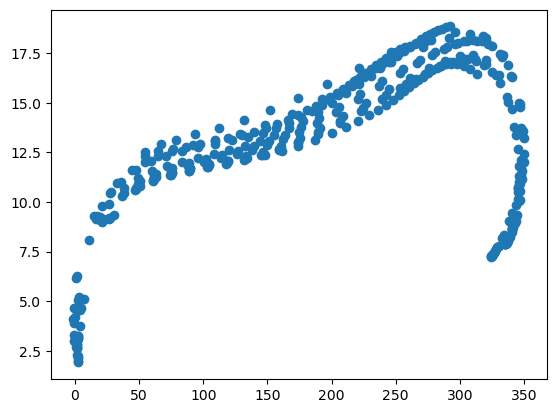

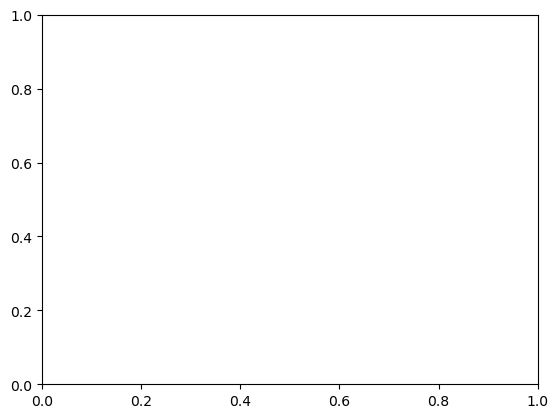

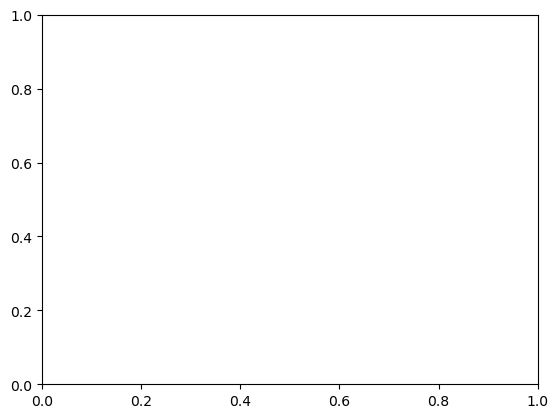

Metrics:
{
  "train": {
    "overall": {
      "MAE": 5.834018460010596,
      "RMSE": 10.177215700442154,
      "R2": 0.7663710374877174
    },
    "per_output": {
      "mean": {
        "MAE": 9.59428821320788,
        "RMSE": 13.843815125553165,
        "R2": 0.9847940107208695
      },
      "std": {
        "MAE": 2.0737487068133045,
        "RMSE": 3.9370320796454794,
        "R2": 0.5479480642545662
      }
    }
  },
  "val": {
    "overall": {
      "MAE": 5.756929790346395,
      "RMSE": 8.663774104929901,
      "R2": 0.8818681720578794
    },
    "per_output": {
      "mean": {
        "MAE": 9.706376021880123,
        "RMSE": 12.023590518896157,
        "R2": 0.9889647721476873
      },
      "std": {
        "MAE": 1.8074835588126625,
        "RMSE": 2.356954500286006,
        "R2": 0.7747715719680717
      }
    }
  },
  "test": {
    "overall": {
      "MAE": 6.70306806952963,
      "RMSE": 10.874660340686606,
      "R2": 0.8140332698149559
    },
    "per_output": {
  

In [17]:
def main(cfg: dict):
    set_seed(cfg["seed"])
    os.makedirs(cfg["out_dir"], exist_ok=True)
    cine_root = Path(cfg["cine_root"]) ; results_root = Path(cfg["results_root"])
    # Load features/targets along with grouping keys and per-sample time for residual plots
    X, Y, groups, times, group_keys = load_frame_stats_to_arrays(
        cine_root, results_root, cfg["repetitions_per_condition"]
    )
    print(f"Loaded dataset: X={X.shape}, Y={Y.shape}")
    # Build split indices: grouped by condition if requested
    if cfg.get("grouped_split", True):
        train_idx, val_idx, test_idx = make_grouped_split(groups, cfg["train_val_test_split"], cfg["seed"])
    else:
        n = X.shape[0]
        train_idx, val_idx, test_idx = make_split(n, cfg["train_val_test_split"], cfg["seed"])
    # Train
    cfg = cfg.copy()
    cfg.update({"train_idx": train_idx, "val_idx": val_idx, "test_idx": test_idx})
    model, dl_tr, dl_v, dl_te, history, scalers = train_model(X, Y, cfg)
    # Evaluate (predictions/targets in raw units with std clamped)
    preds_tr, y_tr, m_tr = evaluate(model, dl_tr, y_scaler_state=scalers["y"], cfg=cfg)
    preds_v,  y_v,  m_v  = evaluate(model, dl_v,  y_scaler_state=scalers["y"], cfg=cfg)
    preds_te, y_te, m_te = evaluate(model, dl_te, y_scaler_state=scalers["y"], cfg=cfg)
    # Gather corresponding times for each split (dataloader maintains order)
    times_tr = times[train_idx]
    times_v  = times[val_idx]
    times_te = times[test_idx]
    # Save
    with open(os.path.join(cfg["out_dir"], "scalers.json"), "w") as f:
        json.dump(scalers, f)
    np.savez(os.path.join(cfg["out_dir"], "predictions.npz"),
             train_preds=preds_tr, train_targets=y_tr,
             val_preds=preds_v, val_targets=y_v,
             test_preds=preds_te, test_targets=y_te,
             times_train=times_tr, times_val=times_v, times_test=times_te,
             group_keys=group_keys)
    metrics = {"train": m_tr, "val": m_v, "test": m_te}
    with open(os.path.join(cfg["out_dir"], "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)
    print("Metrics:")
    print(json.dumps(metrics, indent=2))
    # Persist model configuration for easy inference later
    model_cfg = {
        "in_dim": int(X.shape[1]),
        "out_dim": int(Y.shape[1]),
        "hidden_sizes": cfg["hidden_sizes"],
        "activation": cfg["activation"],
        "dropout": cfg["dropout"],
        "normalization": cfg["normalization"],
        "weight_norm": cfg["weight_norm"],
        "output_activation": cfg["output_activation"],
        "feature_names": cfg.get("feature_names"),
        "target_names": cfg.get("target_names"),
        "standardize_features": cfg.get("standardize_features", True),
        "standardize_targets": cfg.get("standardize_targets", True),
        "std_clamp_min": cfg.get("std_clamp_min", 0.0),
        "frame_rate_hz": cfg.get("frame_rate_hz", 34_000.0),
        "correction_factor": cfg.get("correction_factor", float(1.0 / np.cos(np.deg2rad(20.0)))),
    }
    with open(os.path.join(cfg["out_dir"], "model_config.json"), "w") as f:
        json.dump(model_cfg, f, indent=2)
    # Residual analysis by time
    if cfg.get("plot_residuals", True):
        plot_error_vs_time(cfg["out_dir"], times_tr, y_tr, preds_tr, split_name="train", cfg=cfg)
        plot_error_vs_time(cfg["out_dir"], times_v,  y_v,  preds_v,  split_name="val",   cfg=cfg)
        plot_error_vs_time(cfg["out_dir"], times_te, y_te, preds_te, split_name="test",  cfg=cfg)


if __name__ == "__main__":
    main(CONFIG)